# **Tarea extra** 
# **Machine Learning para físicos**

Vamos a desarrollar una red neuronal artificial desde cero utilizando Numpy. Vamos a programar el modelo más básico de todas las ANN: una feed-forward network. 

Glosario de términos

X = inputs

y = labels

W = weights

b = bias

Z = producto punto entre X y W más b

A = activation(Z)

k = Número de clases

Las letras minúsculas denotan vectores, las letras mayúsculas denotan matrices

# Arquitectura

## Forward Pass

### El producto punto 

Primero, calculamos el producto punto de nuestras entradas y pesos y agregamos un término de sesgo.

$$Z=\sum_{i=1}^{n}\left(Xi * W_i \right)+b$$

En segundo lugar, pasamos la suma ponderada obtenida a través de una función de activación. Estos cálculos tienen lugar en cada neurona en cada capa oculta.

$$A = \sigma(Z)= \sigma \left( \sum_{i=1}^{n}\left[X_i*W_i\right] +b\right)$$


### Funciones de activación comúnmente utilizadas:

En el código vamos a usar la función de activación ReLU en las capas ocultas porque es fácil de diferenciar, y la función de activación Softmax en la capa de salida

Sigmoide
$$f(z) = \frac{1}{1+e^{-z}}$$

Tanh    
$$f(z)=  \frac{e^{z}-e^{-z}}{e^z+e^{-z}} $$

ReLu 
$$f(z)=\left(z, z\geq 0, 0~en~otro~caso \right)$$

## Backward Pass

### La función de pérdida. 

Comenzamos calculando la pérdida, también conocida como el error. Esta es una medida de cuán incorrecto es un modelo. Entrenamos el modelo para minimizar la función de pérdida. La función de pérdida a emplear depende de la tarea que se quiera realizar. En este notebook vamos a usar la entropía cruzada categórica porque se realizará una tarea de clasificación múltiple. Para una tarea de clasificación binaria, es posible la entropía cruzada binaria y, para una tarea de regresión, se puede usar el error cuadrático medio.

Entropía cruzada categórica
$$L = -\frac{1}{m} \sum_{i=1}^{m} y_i \cdot log(\hat{y}_i) ...(1)$$

La fórmula anterior implica que las etiquetas están en one-hot encoding. Keras espera que las etiquetas estén en one-hot encoding. Sin embargo, la implementación aquí realizada no lo hace. 

Tenemos los siguientes datos de una sola muestra, las etiquetas están en one-hot encoding ($y$) y la predicción del modelo es ($\hat{y}$)

In [ ]:
y = [1, 0, 0]
ŷ = [3.01929735e-07, 7.83961013e-09, 9.99999690e-01]

**EJEMPLO**: Calcula la entropía cruzada del paso anterior usando la ecuación (1). Después calcula -log($\hat{y}[0]$)

In [ ]:
import numpy as np
loss = 0
for i in range(0,len(ŷ)):
    loss += -np.log(ŷ[i])*y[i]
print(loss)
print(-np.log(ŷ[0]))

15.013071512205286
15.013071512205286


Como puedes ver, la clase correcta en esta muestra era cero, indicada por un uno en el índice cero de la matriz $y$. Multiplicamos el logaritmo negativo de nuestra probabilidad de salida por la etiqueta correspondiente para esa clase y sumamos todas las clases. A lo que esto se reduce simplemente al logaritmo negativo de nuestra probabilidad en el índice correspondiente para la clase correcta. 

La pérdida total es el promedio de todas las muestras, indicada por $m$ en la ecuación. Para obtener esta cifra, repetimos el cálculo anterior para cada muestra, calculamos la suma y dividimos por el número total de muestras.

### Descenso de gradiente estocástico

Ahora que hemos calculado la pérdida, es hora de minimizarla. Comenzamos calculando el gradiente de nuestras probabilidades de salida con respecto a los parámetros de entrada y retropropagamos (backpropagate) los gradientes a los parámetros en cada capa.

En cada capa, realizamos cálculos similares al pase hacia adelante, excepto que en lugar de realizar los cálculos solo para $Z$ y $A$, tenemos que ejecutar un cálculo para cada parámetro ($dZ$, $dW$, $db$, $dA$), como se muestra a continuación.

Capa oculta

$$\partial Z^{[L]} = \partial A^{[L]}*g'(Z)^{[L]}$$

$$\partial W^{[L]} = \partial A^{[L-1]}_T*\partial Z^{[L]}$$

$$\partial b^{[L]}= \sum_{i}^{m} \partial Z^{[L](i)}$$

$$\partial A^{[L-1]}= \partial Z^{[L]} \cdot W^{[L]}$$

# Implementación NumPy

Usaremos el conjunto de datos de iris para este modelo.

**EJEMPLO:** Importa el conjunto de datos "iris.csv". Asigna a una variable "X" las características y a una variable "y" las etiquetas usando la función LabelEncoder de sklearn.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
def get_data(path):
    data = pd.read_csv(path, index_col=0)
    cols = list(data.columns)
    target = cols.pop()
    X = data[cols].copy()
    y = data[target].copy()
    y = LabelEncoder().fit_transform(y)
    return np.array(X), np.array(y)
X, y = get_data("iris.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inicializar capas

In [ ]:
class DenseLayer:
    def __init__(self, neurons):
        self.neurons = neurons   
    def relu(self, inputs):
        """
        ReLU Activation Function
        """
        return np.maximum(0, inputs)
    def softmax(self, inputs):
        """
        Softmax Activation Function
        """
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    def relu_derivative(self, dA, Z):
        """
        ReLU Derivative Function
        """
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    def forward(self, inputs, weights, bias, activation):
        """
        Single Layer Forward Propagation
        """
        Z_curr = np.dot(inputs, weights.T) + bias

        if activation == 'relu':
          A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
          A_curr = self.softmax(inputs=Z_curr)

        return A_curr, Z_curr
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Single Layer Backward Propagation
        """
        if activation == 'softmax':
          dW = np.dot(A_prev.T, dA_curr)
          db = np.sum(dA_curr, axis=0, keepdims=True)
          dA = np.dot(dA_curr, W_curr) 
        else:
          dZ = self.relu_derivative(dA_curr, Z_curr)
          dW = np.dot(A_prev.T, dZ)
          db = np.sum(dZ, axis=0, keepdims=True)
          dA = np.dot(dZ, W_curr)
        return dA, dW, db

# Inicializar red

In [ ]:
class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            elif idx > 0 and idx < len(self.network)-1:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'softmax'})
        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        np.random.seed(99)
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(low=-1, high=1, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'], activation=self.architecture[i]['activation'])
            
            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)
        
        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores
        
        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self, lr=0.01):
        for idx, layer in enumerate(self.network):
            self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T  
            self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)
        
        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        
        self._init_weights(X_train)
        
        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))
            
            self._backprop(predicted=yhat, actual=y_train)
            
            self._update()
            
            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

# Network — The Forward Pass



### Arquitectura

Comencemos inicializando dinámicamente la arquitectura de red. Esto significa que podemos inicializar nuestra arquitectura de red para un número arbitrario de capas y neuronas.

  def _compile(self, data):

Comenzamos creando una matriz que mapea nuestra dimensionalidad (n.º de características) con el número de neuronas en la capa de entrada. A partir de ahí, es bastante sencillo: la dimensión de entrada de una nueva capa es la cantidad de neuronas en la capa anterior, la dimensión de salida es la cantidad de neuronas en la capa actual.

**EJEMPLO:** Crear una red con tres capas ocultas, la primera con 6 nodos, la segunda con 8 y la última con 10. Emplear la función ._compile(X) e imprimir la arquitectura de la red. 

In [ ]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))
model._compile(X)
print(model.architecture)

[{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'}, {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'}, {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'}, {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]


### Parámetros

Ahora que hemos creado una red, necesitamos una vez más inicializar dinámicamente nuestros parámetros entrenables (W, b), para un número arbitrario de capas/neuronas (_init_weights(self, data)). 

Como pueden ver, estamos creando una matriz de peso en cada capa.

Esta matriz contiene un vector para cada neurona y una dimensión para cada característica de entrada.

Hay un vector de sesgo con una dimensión para cada neurona en una capa.

También observemos que estamos configurando un np.random.seed(), para obtener resultados consistentes cada vez. Intenten comentar esta línea de código para ver cómo afecta sus resultados.



**EJEMPLO:** Con la red neuronal creada con anterioridad, emplear la función _init_weights() e imprimir las dimensiones de $W$ y $b$ en cada capa. 

In [ ]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))
model._init_weights(X)
print(model.params[0]['W'].shape, model.params[0]['b'].shape)
print(model.params[1]['W'].shape, model.params[1]['b'].shape)
print(model.params[2]['W'].shape, model.params[2]['b'].shape)
print(model.params[3]['W'].shape, model.params[3]['b'].shape)

(6, 4) (1, 6)
(8, 6) (1, 8)
(10, 8) (1, 10)
(3, 10) (1, 3)


### Propagación hacia adelante (Forward Propagation)

La función que realiza un paso de avance completo a través de la red:

  _forwardprop(self, data)

Estamos pasando la salida de la capa anterior como entrada a la siguiente, denotada por A_prev.

Estamos almacenando las entradas y la suma ponderada en la memoria del modelo. Esto es necesario para realizar el pase hacia atrás.

# Capas: el pase hacia adelante (Forward Pass)

### Funciones de activación

ReLU

Es la que usamos en las capas ocultas. Esto es lo que sucede cuando llamamos a np.maximum().

  if input > 0:

    return input
  
  else:
  
    return 0

softmax

Utilizado en la capa final. Esta función toma un vector de entrada de k valores reales y lo convierte en un vector de k probabilidades que suman uno.

$$\sigma(\vec{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$$

### Propagación directa de una sola capa (Single Layer Forward Propagation)

  forward(self, inputs, weights, bias, activation)

Dónde:

     inputs = A_prev
     weights = matriz de peso de la capa actual
     bias = vector de sesgo de la capa actual
     activación = función de activación de la capa actual

Llamamos a esta función en el método _forwardprop de la red y pasamos los parámetros de la red como entrada.

### Realizar un Forward Pass

**EJEMPLO:** Con la red neuronal anterior, empleaR la función forwardprop() para realizar un paso hacia adelante. Imprimir las dimensiones de salida, las probabilidades del primer elemento de salida y compruebar que la suma es 1. 

In [ ]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))
model._init_weights(X)
out = model._forwardprop(X)
print('SHAPE:', out.shape)
print('Probabilties at idx 0:', out[0])
print('SUM:', sum(out[0]))

SHAPE: (150, 3)
Probabilties at idx 0: [9.99998315e-01 1.07470169e-06 6.10266912e-07]
SUM: 1.0


Se obtienen 150 instancias asignadas a las 3 clases y una distribución de probabilidad para cada instancia que suma 1.

# El pase hacia atrás (The Backward Pass)

### Retropropagación (Backpropagation)

La función que realiza un paso hacia atrás completo a través de la red: _backprop(self, predicted, actual). 

Comenzamos calculando el gradiente de nuestros scores. Denotado por dscores. 

“deseamos entender cómo deberían cambiar los valores calculados dentro de z para disminuir la pérdida Li que este ejemplo contribuye al objetivo completo. En otras palabras, queremos derivar el gradiente ∂Li/∂zk.

La pérdida Li se calcula a partir de p, que a su vez depende de z.

$$\frac{\partial L_i}{\partial Z_k} = p_k -1 (y_i=k)$$

Donde 

$$L_i = -log (p_{y_i})$$

$$p_k = \frac{e^{z_k}}{\sum_{j}^{k} e^{z_j}}$$

Ejemplo de muestra única:

Para cada muestra encontramos el índice de la clase correcta y restamos uno. Esta es la línea 9 de _backprop(self, predicted, actual). Dado que dscores es una matriz, podemos duplicar el índice utilizando la muestra y la etiqueta de clase correspondiente.

Vector de entrada = [9.99998315e-01, 1.07470169e-06, 6.10266912e-07]

Vector de salida = [-1.68496861e-06, 1.07470169e-06, 6.10266912e-07]

Aquí el índice correcto es cero, por lo que restamos 1 del índice cero.

Observen que comenzamos en la capa de salida y pasamos a la capa de entrada.

# Capas: el pase hacia atrás
### Derivado de activación

relu_derivative(self, dA, Z)

$$\partial Z^{[L]}= \partial A^{[L]}*g'(Z^{[L]})$$

### Propagación hacia atrás de una sola capa

Esta función retropropaga los gradientes a cada parámetro en una capa backward(self, dA_curr, W_curr, Z_curr, A_prev, activation). 



# Realizar pase hacia atrás (Backward Pass)

**Ejemplo:** Emplear la red definida con anterioridad, inicializar los pesos, realizar un paso hacia adelante con forwardprop(). Emplear _backprop() para obtener los resultados del paso hacia atrás. Imprimir las dimensiones de $W$ y $dW$ entre cada capa.

In [ ]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))
model._init_weights(X)
out = model._forwardprop(X)
model._backprop(predicted=out, actual=y)
print(model.gradients[0]['dW'].shape, model.params[3]['W'].shape)
print(model.gradients[1]['dW'].shape, model.params[2]['W'].shape)
print(model.gradients[2]['dW'].shape, model.params[1]['W'].shape)
print(model.gradients[3]['dW'].shape, model.params[0]['W'].shape)

(10, 3) (3, 10)
(8, 10) (10, 8)
(6, 8) (8, 6)
(4, 6) (6, 4)


los gradientes se calculan a partir de la capa de salida y retroceden hasta la capa de entrada.

### Entrenar al modelo

Se realiza una actualización de parámetros después de cada iteración (época). Esto es posible mediante el método `_update.`

El método train() junta los métodos _update(), _calculate_loss() y _get_accuracy(). 

**Ejercicio:** Con la red definida con anterioridad. Entrenar el modelo con 200 iteraciones. 

In [ ]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))
model.train(X, y, 200)

EPOCH: 0, ACCURACY: 0.3333333333333333, LOSS: 8.40744717002989
EPOCH: 20, ACCURACY: 0.4, LOSS: 0.9215854842299206
EPOCH: 40, ACCURACY: 0.43333333333333335, LOSS: 0.7536116948198673
EPOCH: 60, ACCURACY: 0.42, LOSS: 0.6714779014672262
EPOCH: 80, ACCURACY: 0.41333333333333333, LOSS: 0.6594143979448669
EPOCH: 100, ACCURACY: 0.6666666666666666, LOSS: 0.5259943503852045
EPOCH: 120, ACCURACY: 0.6666666666666666, LOSS: 0.4706373583820736
EPOCH: 140, ACCURACY: 0.6666666666666666, LOSS: 0.5053203560733266
EPOCH: 160, ACCURACY: 0.48, LOSS: 1.0150613941350863
EPOCH: 180, ACCURACY: 0.8333333333333334, LOSS: 0.460658552975821


### Examinar los resultados
Para cada época se guardan los valores correspondientes a la precición (Accuracy) y la pérdida (loss). 

**EJEMPLO:** ImprimIR las gráficas correspondientes para inferir más sobre el modelo.

Text(0.5, 1.0, 'Numpy Model Accuracy')

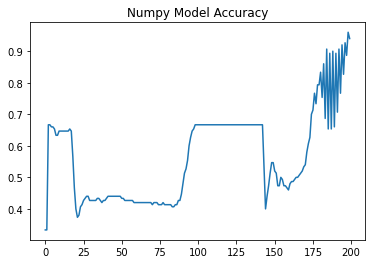

In [ ]:
plt.plot(model.accuracy)
plt.title('Numpy Model Accuracy')

Text(0.5, 1.0, 'Numpy Model Loss')

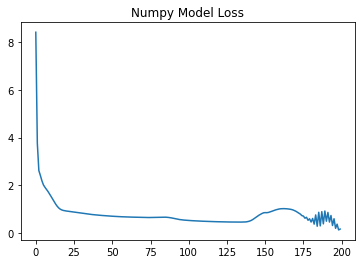

In [ ]:
plt.plot(model.loss)
plt.title('Numpy Model Loss')

### Probar con diferentes arquitecturas de red

**EJEMPLO:** Probar diferentes arquitecturas para una red ANN y graficar los resultados. 

In [ ]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(3))
model.train(X, y, 200)

EPOCH: 0, ACCURACY: 0.3333333333333333, LOSS: 3.9855949144057026
EPOCH: 20, ACCURACY: 0.4266666666666667, LOSS: 0.6308065478680575
EPOCH: 40, ACCURACY: 0.44666666666666666, LOSS: 0.5999167210329991
EPOCH: 60, ACCURACY: 0.4533333333333333, LOSS: 0.5702574248413287
EPOCH: 80, ACCURACY: 0.54, LOSS: 0.5396462156531233
EPOCH: 100, ACCURACY: 0.62, LOSS: 0.5067118680121276
EPOCH: 120, ACCURACY: 0.78, LOSS: 0.47066375648495695
EPOCH: 140, ACCURACY: 0.8533333333333334, LOSS: 0.43581286104700195
EPOCH: 160, ACCURACY: 0.8933333333333333, LOSS: 0.40474595549017295
EPOCH: 180, ACCURACY: 0.94, LOSS: 0.3805415662407408


Text(0.5, 1.0, 'Numpy Model Accuracy')

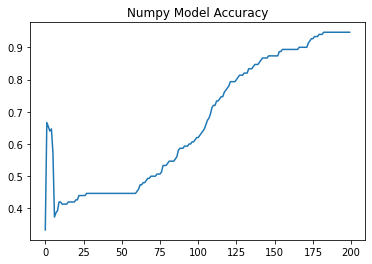

In [ ]:
plt.plot(model.accuracy)
plt.title('Numpy Model Accuracy')

Text(0.5, 1.0, 'Numpy Model Loss')

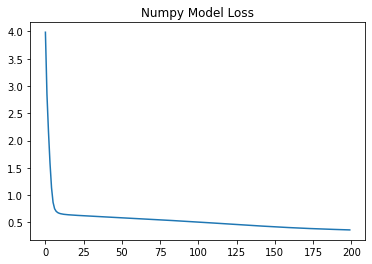

In [ ]:
plt.plot(model.loss)
plt.title('Numpy Model Loss')

# Un modelo equivalente en Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
ohy = tf.keras.utils.to_categorical(y, num_classes=3)
model2 = Sequential()
model2.add(Dense(6, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(3, activation='softmax'))
model2.compile(SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(x=X, y=ohy, epochs=30)

Epoch 1/30
5/5 [==============================] - 1s 3ms/step - loss: 1.1060 - accuracy: 0.3333
Epoch 2/30
5/5 [==============================] - 0s 2ms/step - loss: 1.1028 - accuracy: 0.3333
Epoch 3/30
5/5 [==============================] - 0s 2ms/step - loss: 1.0994 - accuracy: 0.3333
Epoch 4/30
5/5 [==============================] - 0s 3ms/step - loss: 1.0958 - accuracy: 0.3467
Epoch 5/30
5/5 [==============================] - 0s 4ms/step - loss: 1.0918 - accuracy: 0.5067
Epoch 6/30
5/5 [==============================] - 0s 3ms/step - loss: 1.0877 - accuracy: 0.6133
Epoch 7/30
5/5 [==============================] - 0s 3ms/step - loss: 1.0831 - accuracy: 0.6333
Epoch 8/30
5/5 [==============================] - 0s 3ms/step - loss: 1.0771 - accuracy: 0.4667
Epoch 9/30
5/5 [==============================] - 0s 2ms/step - loss: 1.0715 - accuracy: 0.4133
Epoch 10/30
5/5 [==============================] - 0s 2ms/step - loss: 1.0665 - accuracy: 0.4000
Epoch 11/30
5/5 [======================

### Examinar los resultados

Text(0.5, 1.0, 'Numpy Model Accuracy')

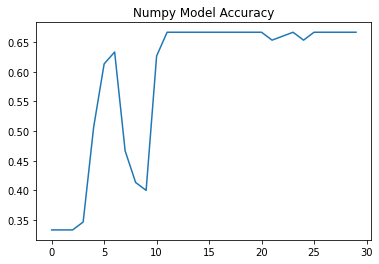

In [ ]:
plt.plot(model2.history.history['accuracy'])
plt.title('Keras Model Accuracy')

Text(0.5, 1.0, 'Keras Model Loss')

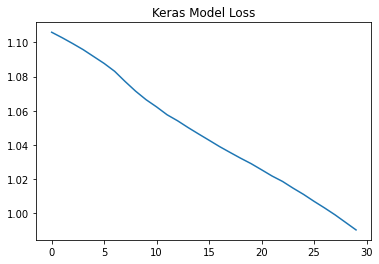

In [ ]:
plt.plot(model2.history.history['loss'])
plt.title('Keras Model Loss')

Keras no establece random.seed(), por lo que se obtendran diferentes resultados entre cada ejecución. Si se elimina esa línea del método _init_weights, la red NumPy se comporta de la misma manera.

**Ejercicio:**

1. Descarga una base de datos con etiquetas para clasificación (puedes usar el siguiente link: https://www.kaggle.com/)
2. Usa el código de Numpy para generar una red ANN que no emplee necesariamente la función ReLu entre capas ocultas. 
3. Entrena la red neuronal explicando detalladamemte lo que el código hace. 
4. Imprime los gráficos y discute los resultados. 
5. Genera el mismo modelo de red neuronal empleando Keras y Pytorch (es decir, dos modelos, uno por framework). 

**Ejercicio:** 

1. Descarga dos bases de datos. Una de imágenes para clasificación y una de secuencia (serie de tiempo). 
2. Genera un modelo de redes neuronales CNN y uno RNN (el dataset de imágenes se empleará para la red CNN y el de secuencia para la RNN), usando Keras o Pytorch. Varía todos los hiperparámetros que consideres necesarios para obtener un buen modelo. Incluso, emplea métodos de regularización en caso de considerarlo pertinente.  
3. Explica detalladamente cada modelo.
4. Imprime el gráfico de pérdida contra el número de épocas. Para la red CNN, muestra la curva ROC y la matriz de confusión. 
5. Discute los resultados.  